## NN Prediction

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
PYTHON_PATHS = [".."]
import sys
for path in PYTHON_PATHS:
    if path not in sys.path:
        sys.path.append(path)

import torch
import torch.nn as nn
from models.classifier import Classifier
from models.regressor import Regressor
from data_loader.orb_features_data_module import ORBFeaturesDataModule
from data_loader.orb_classifier_dataset import ORBClsDataset
from data_loader.orb_regressor_dataset import ORBRegDataset
import pytorch_lightning as pl
import numpy as np
from matplotlib import pyplot as plt
from tqdm.auto import tqdm

## Regressor

In [3]:
reg_model = Regressor(512, [512], 1, train_backbone=True)

network head
Sequential(
  (0): Linear(in_features=512, out_features=512, bias=True)
  (1): ReLU()
  (2): Linear(in_features=512, out_features=512, bias=True)
  (3): ReLU()
  (4): Linear(in_features=512, out_features=1, bias=True)
)


Using cache found in /home/quetalasj/.cache/torch/hub/pytorch_vision_v0.10.0


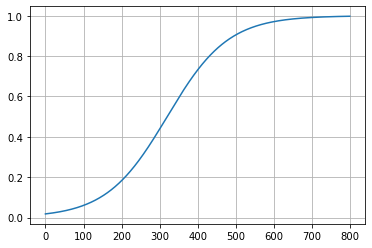

In [4]:


def sigmoid_function(x, x0=400, k=0.01):
    y = 1. / (1. + np.exp(-k*(x-x0))).astype(np.float64)
    return y


plt.plot(sigmoid_function(np.linspace(0, 1000, 800)))
plt.grid()
plt.show()
         

In [5]:
reg_dataset = ORBRegDataset("/home/quetalasj/datasets/orb-cls/",
                             ["dataset_2_cam_0",
                              "dataset_2_cam_1",
                              "dataset_2_cam_2",
                              "dataset_2_cam_3",
                              "dataset_2_cam_5",
                              
                              "dataset_3_cam_0",
                              "dataset_3_cam_1",
                              "dataset_3_cam_2",
                              "dataset_3_cam_3",
                              "dataset_3_cam_5"
                             ],
                             sigmoid_function,
                             transform=reg_model.transform)

datamodule = ORBFeaturesDataModule(reg_dataset, 
                                   batch_size=128+32,
                                   shuffle=True,
                                   num_workers=6,
                                   num_val=1000,
                                   num_test=1000)

datasetname: dataset_2_cam_0
num images: 2546
num labels: 2546
datasetname: dataset_2_cam_1
num images: 2546
num labels: 2546
datasetname: dataset_2_cam_2
num images: 2546
num labels: 2546
datasetname: dataset_2_cam_3
num images: 2546
num labels: 2546
datasetname: dataset_2_cam_5
num images: 2546
num labels: 2546
datasetname: dataset_3_cam_0
num images: 6376
num labels: 6376
datasetname: dataset_3_cam_1
num images: 6376
num labels: 6376
datasetname: dataset_3_cam_2
num images: 6376
num labels: 6376
datasetname: dataset_3_cam_3
num images: 6376
num labels: 6376
datasetname: dataset_3_cam_5
num images: 6376
num labels: 6376


In [6]:
trainer = pl.Trainer(gpus=1, log_every_n_steps=1, max_epochs=6)
trainer.fit(reg_model, datamodule)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type       | Params
------------------------------------------
0 | activation | Sigmoid    | 0     
1 | loss       | MSELoss    | 0     
2 | backbone   | ResNet     | 11.2 M
3 | fc         | Sequential | 525 K 
------------------------------------------
11.7 M    Trainable params
0         Non-trainable params
11.7 M    Total params
46.809    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [7]:
reg_model = reg_model.eval()
reg_model = reg_model.cuda()
cam_0 = ORBRegDataset("/home/quetalasj/datasets/orb-cls/",
                             ["dataset_1_cam_1"],
                             sigmoid_function,
                             transform=reg_model.transform)

# cam_3 = ORBRegDataset("/home/quetalasj/datasets/orb-cls/",
#                              ["dataset_3_cam_3"],
#                              sigmoid_function,
#                              transform=reg_model.transform)

predicts_0 = []
for img, label in tqdm(cam_0):
    predict = reg_model.activation(reg_model.forward(img[None,...].to('cuda:0')))
    predicts_0.append(predict.detach().cpu().numpy()[0])

datasetname: dataset_1_cam_1
num images: 3824
num labels: 3824


  0%|          | 0/3824 [00:00<?, ?it/s]

In [10]:
# predicts_3 = []
# for img, label in tqdm(cam_3):
#     predict = reg_model.activation(reg_model.forward(img[None,...].to('cuda:0')))
#     predicts_3.append(predict.detach().cpu().numpy()[0])

  0%|          | 0/6376 [00:00<?, ?it/s]

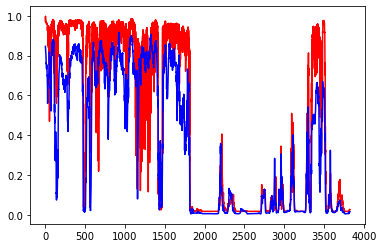

In [8]:
# 1 epoch
plt.plot(cam_0.labels, c = 'red')
plt.plot(predicts_0, c='blue')
# plt.plot(predicts_3, c='green')
plt.show()

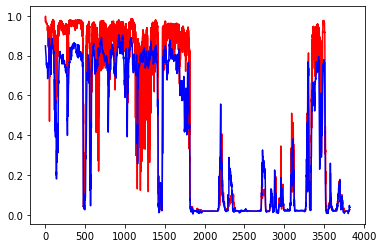

In [8]:
# 2 epochs
plt.plot(cam_0.labels, c = 'red')
plt.plot(predicts_0, c='blue')
# plt.plot(predicts_3, c='green')
plt.show()

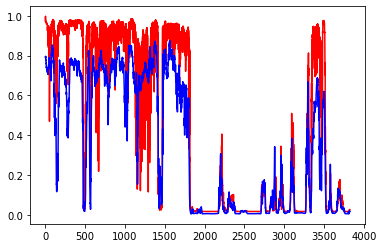

In [8]:
# 3 epocs
plt.plot(cam_0.labels, c = 'red')
plt.plot(predicts_0, c='blue')
# plt.plot(predicts_3, c='green')
plt.show()

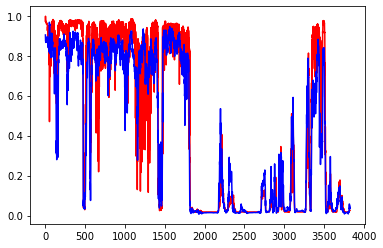

In [8]:
# 6 epocs
plt.plot(cam_0.labels, c = 'red')
plt.plot(predicts_0, c='blue')
# plt.plot(predicts_3, c='green')
plt.show()

In [9]:
trainer.save_checkpoint("1_regressor_2d_6_ep.ckpt")

In [15]:
saved_model = Regressor.load_from_checkpoint("1_regressor_2d_6_ep.ckpt", in_size=512, hidden_sizes=[512], out_size=1)

network head
Sequential(
  (0): Linear(in_features=512, out_features=512, bias=True)
  (1): ReLU()
  (2): Linear(in_features=512, out_features=512, bias=True)
  (3): ReLU()
  (4): Linear(in_features=512, out_features=1, bias=True)
)


Using cache found in /home/quetalasj/.cache/torch/hub/pytorch_vision_v0.10.0


In [16]:
saved_model = saved_model.eval()
saved_model = saved_model.cuda()


predicts_0 = []
for img, label in tqdm(cam_0):
    predict = saved_model.activation(saved_model.forward(img[None,...].to('cuda:0')))
    predicts_0.append(predict.detach().cpu().numpy()[0])

  0%|          | 0/3824 [00:00<?, ?it/s]

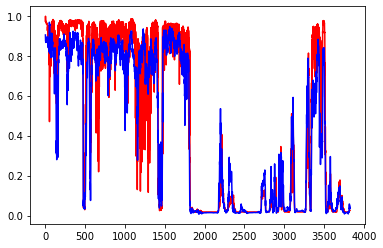

In [18]:
# test saved model
plt.plot(cam_0.labels, c = 'red')
plt.plot(predicts_0, c='blue')
# plt.plot(predicts_3, c='green')
plt.show()